### Medical Analyst With Human Loop

There are typically three different actions that you can do with a human-in-the-loop workflow:

Approve or Reject: Pause the graph before a critical step, such as an API call, to review and approve the action. If the action is rejected, you can prevent the graph from executing the step, and potentially take an alternative action. This pattern often involve routing the graph based on the human's input.

Edit Graph State: Pause the graph to review and edit the graph state. This is useful for correcting mistakes or updating the state with additional information. This pattern often involves updating the state with the human's input.

Get Input: Explicitly request human input at a particular step in the graph. This is useful for collecting additional information or context to inform the agent's decision-making process or for supporting multi-turn conversations.



In [8]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user sent "Hello". That\'s a friendly greeting. I should respond in a welcoming and open manner. Maybe ask how I can assist them. Keep it simple and positive. Let them know I\'m here to help with any questions or tasks they have. Make sure the response is concise but warm.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 9, 'total_tokens': 88, 'completion_time': 0.162782159, 'prompt_time': 0.000413304, 'queue_time': 0.091552455, 'total_time': 0.163195463}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--e33d307f-0fae-4d7e-9fa6-31f577beb855-0', usage_metadata={'input_tokens': 9, 'output_tokens': 79, 'total_tokens': 88})

In [9]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel,Field

class MedicalAnalyst(BaseModel):
    affiliation:str=Field(
        description="Primary qualification of the medical anaylyst"
    )
    name:str=Field(
        description="Name of the Medical Analyst "
    )
    role:str=Field(
        description="Role of the medical analyst in the context of the research topic",
    )
    description:str=Field(
        description="Description of the medical analyst research focus,concerns and research objectives to achieve"
    )
    @property
    def persona(self)->str:
        return f" Name:{self.name} \n Role:{self.role} \n affiliation:{self.affiliation}\n Description:{self.description}\n"


class Perspectives(BaseModel):
    medicalanalysts:List[MedicalAnalyst]=Field(
        description="Comprehensive list of medical analyst with there roles and affiliations "
    )

class GenerateMedicalAnalystState(TypedDict):
    researchTopic:str # Research topic
    max_medical_analysts:int # number of analysts
    human_analyst_feedback:str # human feedback
    medicalanalysts:List[MedicalAnalyst] #Medical analyst asking questions


In [10]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

medical_analyst_instructions="""You are tasked with creating a set of Medical AI analyst personas. Follow these instructions carefully:

1. First, review the medical research topic:
{researchTopic}
        
2. Examine any medical editorial feedback or medical research   that has been optionally provided to guide creation of the medical analysts that will work to generate medicines for the research or you can your own knowledge for this task: 
        
{human_analyst_feedback}
    
3. Determine the most interesting research parts based upon documents and / or feedback above.
                    
4. Pick the top {max_medical_analysts} research.

5. Assign one analyst to each research part."""

In [11]:
def  create_medical_analysts(state:GenerateMedicalAnalystState):
    """Create medical analysts"""

    researchTopic=state["researchTopic"]
    max_medical_analysts=state["max_medical_analysts"]
    human_analyst_feedback=state.get('human_analyst_feedback')

    #Enforece structured output
    structured_llm=llm.with_structured_output(Perspectives)

    #System message
    system_message=medical_analyst_instructions.format(researchTopic=researchTopic,
                                                       human_analyst_feedback=human_analyst_feedback,
                                                       max_medical_analysts=max_medical_analysts)
    
    #Generate questions

    analysts=structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of medical analyst")])

    #Write the list of analysis to state
    return {"medicalanalysts":analysts.medicalanalysts}


In [12]:
def human_feedback(state:GenerateMedicalAnalystState):
    """No operation node that should be interrupted"""
    pass

In [13]:
def should_continue(state:GenerateMedicalAnalystState):
    """Return the next node to execute"""

    #check if human feedback

    human_analyst_feedback=state.get("human_analyst_feedback",None)
    if( human_analyst_feedback):
        return "create_medical_analysts"
    return END


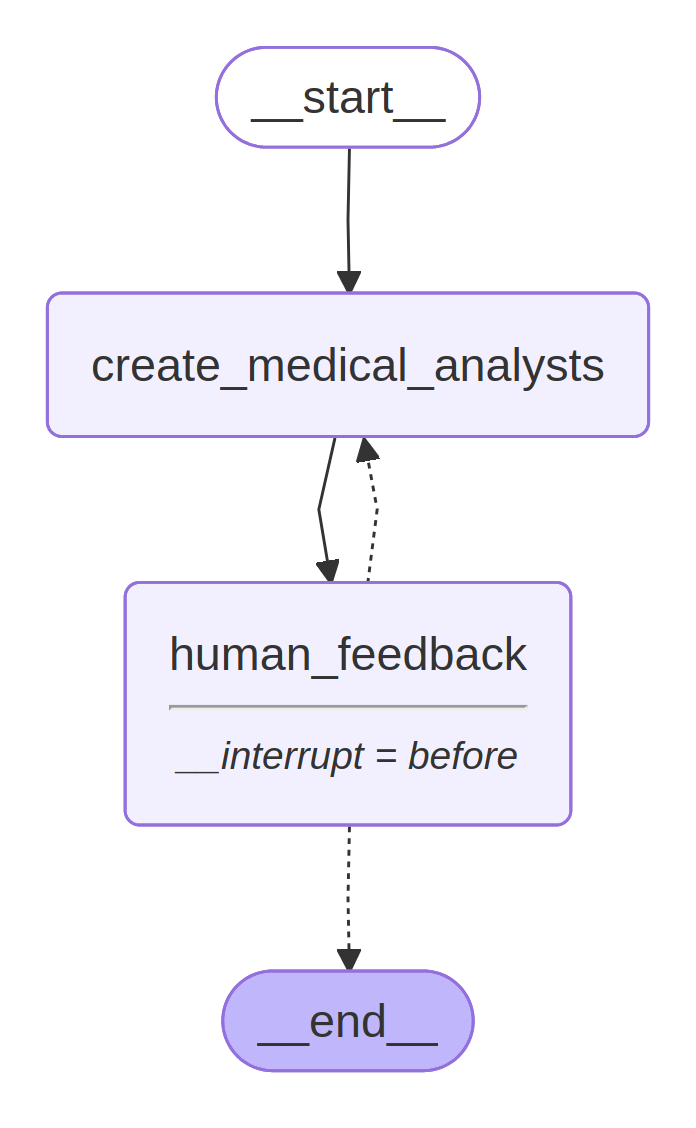

In [14]:
#Add nodes and edges 

medical_analyst_builder=StateGraph(GenerateMedicalAnalystState)

medical_analyst_builder.add_node("create_medical_analysts",create_medical_analysts)
medical_analyst_builder.add_node("human_feedback",human_feedback)
medical_analyst_builder.add_edge(START,"create_medical_analysts")
medical_analyst_builder.add_edge("create_medical_analysts","human_feedback")
medical_analyst_builder.add_conditional_edges("human_feedback",should_continue,["create_medical_analysts",END])
#compile

memory=MemorySaver()
graph=medical_analyst_builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

#View
#display(Image(graph.get_graph().draw_mermaid_png()))

from langchain_core.runnables.graph import MermaidDrawMethod

import nest_asyncio
nest_asyncio.apply()

png = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(png))




In [ ]:
# Input
max_medical_analysts=4
topic="Vaccines for  chicken pox diseases"
thread={"configurable":{"thread_id":"1"}}


In [16]:
# Run the graph until the first interruption
for event in graph.stream({"researchTopic":topic,"max_medical_analysts":max_medical_analysts},thread,stream_mode="values"):
     analysts=event.get("medicalanalysts",'')
     if analysts:
          for analyst in analysts:
               print(f"Name :{analyst.name}")
               print(f"Affiliation:{analyst.affiliation}" )
               print(f"Role:{analyst.role}")
               print(f"Description:{analyst.description}")
               print("-"*50)

Name :Dr. Emily Carter
Affiliation:National Institute of Allergy and Infectious Diseases (NIAID)
Role:Vaccine Efficacy Researcher
Description:Focuses on analyzing clinical trial data to determine the long-term efficacy of chickenpox vaccines in different demographic groups, with a goal of optimizing dosing strategies.
--------------------------------------------------
Name :Dr. Raj Patel
Affiliation:Centers for Disease Control and Prevention (CDC)
Role:Adverse Event Monitor
Description:Specializes in tracking post-vaccination adverse events and rare complications to ensure safety profiles align with WHO standards.
--------------------------------------------------
Name :Dr. Ana Morales
Affiliation:Johns Hopkins School of Medicine
Role:Vaccine Immunologist
Description:Investigates immune response mechanisms to chickenpox vaccines, aiming to improve protection duration and reduce breakthrough infections.
--------------------------------------------------
Name :Dr. Michael Chen
Affiliatio

In [17]:
state=graph.get_state(thread)


In [18]:
state.next

('human_feedback',)

In [19]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a research for children chicken pox"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09d45d-5e0b-615b-8002-c38d33b9f8db'}}

In [20]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('medicalanalysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: National Institute of Allergy and Infectious Diseases (NIAID)
Role: Vaccine Efficacy Researcher
Description: Focuses on analyzing clinical trial data to determine the long-term efficacy of chickenpox vaccines in different demographic groups, with a goal of optimizing dosing strategies.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Centers for Disease Control and Prevention (CDC)
Role: Adverse Event Monitor
Description: Specializes in tracking post-vaccination adverse events and rare complications to ensure safety profiles align with WHO standards.
--------------------------------------------------
Name: Dr. Ana Morales
Affiliation: Johns Hopkins School of Medicine
Role: Vaccine Immunologist
Description: Investigates immune response mechanisms to chickenpox vaccines, aiming to improve protection duration and reduce breakthrough infections.
--------------------------------------------------
Name: Dr. Michael Chen
A

In [21]:
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09d45d-7151-6ffa-8004-7f3d8afbf00b'}}

In [22]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [23]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('medicalanalysts')

In [24]:
analysts

[MedicalAnalyst(affiliation='Pediatric Infectious Disease Research Institute', name='Dr. Emily Carter', role='Pediatric Vaccine Immunologist', description='Focuses on optimizing vaccine efficacy in children under 10 years old, studying long-term immunity, and addressing vaccine hesitancy in pediatric populations.'),
 MedicalAnalyst(affiliation='Global Vaccine Safety Network', name='Dr. Raj Patel', role='Pharmacovigilance Specialist', description='Monitors adverse effects of chickenpox vaccines, particularly in immunocompromised children, and develops safety guidelines for pediatric use.'),
 MedicalAnalyst(affiliation='Molecular Virology Lab', name='Dr. Sarah Kim', role='Vaccine Development Scientist', description='Investigates next-generation chickenpox vaccine candidates using mRNA technology to improve protection against varicella-zoster virus reactivation.'),
 MedicalAnalyst(affiliation='Public Health Epidemiology Division', name='Dr. Michael Torres', role='Health Policy Analyst', d

In [25]:
final_state.next

()

In [26]:
analysts

[MedicalAnalyst(affiliation='Pediatric Infectious Disease Research Institute', name='Dr. Emily Carter', role='Pediatric Vaccine Immunologist', description='Focuses on optimizing vaccine efficacy in children under 10 years old, studying long-term immunity, and addressing vaccine hesitancy in pediatric populations.'),
 MedicalAnalyst(affiliation='Global Vaccine Safety Network', name='Dr. Raj Patel', role='Pharmacovigilance Specialist', description='Monitors adverse effects of chickenpox vaccines, particularly in immunocompromised children, and develops safety guidelines for pediatric use.'),
 MedicalAnalyst(affiliation='Molecular Virology Lab', name='Dr. Sarah Kim', role='Vaccine Development Scientist', description='Investigates next-generation chickenpox vaccine candidates using mRNA technology to improve protection against varicella-zoster virus reactivation.'),
 MedicalAnalyst(affiliation='Public Health Epidemiology Division', name='Dr. Michael Torres', role='Health Policy Analyst', d